In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    # Encode categorical columns
    df = df_label_encoder(df, ['nameOrig', 'nameDest', 'type'])  # Example PaySim categorical columns

    # Normalize the 'amount' and other numeric columns
    df['amount'] = (df['amount'] - df['amount'].min()) / (df['amount'].max() - df['amount'].min())

    # Create unique node identifiers
    df['node_from'] = df['nameOrig'].astype(str)  # Origin accounts as nodes
    df['node_to'] = df['nameDest'].astype(str)  # Destination accounts as nodes

    # Sort values by 'node_from' for consistency
    df = df.sort_values(by=['node_from'])

    # Create a list of unique nodes (accounts)
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()

    return df, node_list

In [4]:
# Step 2: Create Graph Data Without torch_geometric
def create_graph_data(df, node_list):
    # Create a mapping of node names to indices
    node_map = {node: idx for idx, node in enumerate(node_list)}

    # Convert edges to indices
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T

    # Node features (converted to numpy array or tensor)
    node_features = torch.tensor(df[['amount', 'type']].values, dtype=torch.float)  # Example feature columns

    # Labels (0 for non-fraud, 1 for fraud)
    labels = torch.tensor(df['isFraud'].values, dtype=torch.long)

    return node_features, edge_index, labels

In [5]:
# Load PaySim dataset and preprocess
df = pd.read_csv('paysim/paysim.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [7]:
# Plot class distribution before augmentation
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

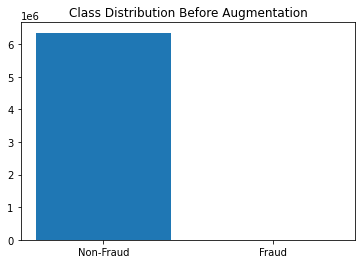

In [8]:
plot_class_distribution(labels, "Class Distribution Before Augmentation")

In [9]:
# GAN Architecture
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(z))

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [11]:
# GAN parameters
input_size = node_features.shape[1]  # Number of node features
hidden_size = 128
output_size = input_size  # Output size matches input for node features
latent_size = 64

In [12]:
# Initialize GAN components
generator = Generator(latent_size, hidden_size, output_size)
discriminator = Discriminator(input_size, hidden_size)

In [13]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [14]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [15]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(node_features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([0.0019, 1.7141]), Initial Variance: tensor([4.2668e-05, 1.8228e+00]), Initial Std Dev: tensor([0.0065, 1.3501])


In [16]:
num_epochs = 10
target_minority_class = torch.sum(labels == 0)  # We want to match the majority class count
real_data = node_features[labels == 1]  # Fraud samples (minority class)

In [17]:
# GAN Training Loop
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Generate fake data
    z = torch.randn(real_data.size(0), latent_size)
    fake_data = generator(z)
    
    # Train Discriminator
    optimizer_d.zero_grad()
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data.detach())  # Detach fake data when training discriminator
    loss_d = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))
    loss_d.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    d_fake = discriminator(fake_data)  # Don't detach here - we want gradients to flow to generator
    loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
    loss_g.backward()
    optimizer_g.step()

    # Add generated samples to dataset
    with torch.no_grad():
        labels = torch.cat((labels, torch.ones(fake_data.size(0), dtype=torch.long)))  # Changed to ones since these are fraud cases
        node_features = torch.cat((node_features, fake_data))

    if epoch % 2 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}')


Epoch [0/10], D Loss: 1.2788, G Loss: 0.5977
Epoch [2/10], D Loss: 1.2553, G Loss: 0.5933
Epoch [4/10], D Loss: 1.2348, G Loss: 0.5920
Epoch [6/10], D Loss: 1.2157, G Loss: 0.5943
Epoch [8/10], D Loss: 1.1981, G Loss: 0.5993


In [18]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))  # Generate samples
y_generated = torch.ones(num_generated_samples, dtype=torch.long)  # Label these as fraudulent (minority class)

In [19]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

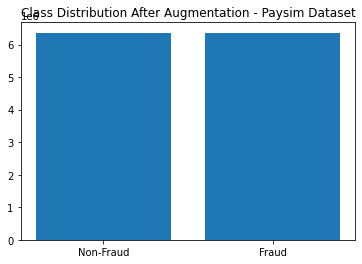

In [20]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation - Paysim Dataset")

In [21]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

Final Mean: tensor([0.2835, 1.2016], grad_fn=<MeanBackward1>), Final Variance: tensor([0.0805, 1.1763], grad_fn=<VarBackward0>), Final Std Dev: tensor([0.2838, 1.0846], grad_fn=<StdBackward0>)


In [22]:
# Assuming real_data is your actual node features labeled as fraud (real minority class)
real_data = node_features[labels == 1]  # Take only fraud samples (minority class)

# If generated_data has more samples than real_data, we need to match their size
min_size = min(real_data.size(0), generated_data.size(0))

# Subsample real and generated data to have the same number of rows
real_data_sampled = real_data[:min_size]
generated_data_sampled = generated_data[:min_size]

# Function to compute R-squared
def r_squared(real_data, generated_data):
    ss_res = torch.sum((real_data - generated_data) ** 2, dim=0)  # Residual sum of squares
    ss_tot = torch.sum((real_data - torch.mean(real_data, dim=0)) ** 2, dim=0)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [23]:
# Compute R-squared between the real and generated data samples
r2_scores = r_squared(real_data_sampled, generated_data_sampled)
print(f"R-squared for each feature: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean()}")

R-squared for each feature: tensor([-0.4941, -0.0284], grad_fn=<RsubBackward1>)
Mean R-squared: -0.2612758278846741


In [24]:
# Split Data into Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.2, random_state=42)

In [25]:
# Define Classifier Model
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [26]:
# Training Classifier on Balanced Dataset
classifier = Classifier(input_size, hidden_size)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

# Classifier Training Loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(30):
    # Training phase
    classifier.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = classifier(x_train)
    loss = loss_fn(y_pred, y_train)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Record training metrics
    train_losses.append(loss.item())
    
    # Computing training accuracy
    with torch.no_grad():
        train_accuracy = accuracy_score(y_train.cpu().numpy(), y_pred.argmax(dim=1).cpu().numpy())
        train_accuracies.append(train_accuracy)
    
    # Evaluation phase
    classifier.eval()
    with torch.no_grad():
        y_test_pred = classifier(x_test)
        test_loss = loss_fn(y_test_pred, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred.argmax(dim=1).cpu().numpy())
        test_accuracies.append(test_accuracy)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

Epoch 0, Train Loss: 0.5390, Test Loss: 0.5015, Train Acc: 0.9860, Test Acc: 0.9861
Epoch 5, Train Loss: 0.3816, Test Loss: 0.3581, Train Acc: 0.9860, Test Acc: 0.9861
Epoch 10, Train Loss: 0.2840, Test Loss: 0.2694, Train Acc: 0.9860, Test Acc: 0.9861
Epoch 15, Train Loss: 0.2227, Test Loss: 0.2133, Train Acc: 0.9860, Test Acc: 0.9861
Epoch 20, Train Loss: 0.1826, Test Loss: 0.1763, Train Acc: 0.9860, Test Acc: 0.9861
Epoch 25, Train Loss: 0.1553, Test Loss: 0.1510, Train Acc: 0.9860, Test Acc: 0.9861


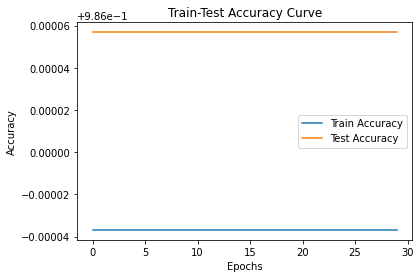

In [28]:
# Plot Train-Test Accuracy Curve
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train-Test Accuracy Curve")
plt.show()

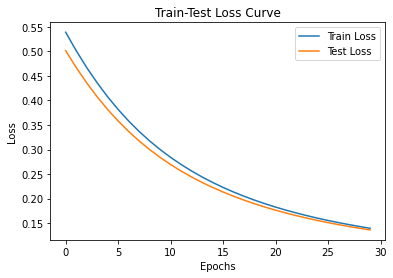

In [29]:
# Plot Train-Test Loss Curve
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train-Test Loss Curve")
plt.show()

In [30]:
# Compute Confusion Matrix and ROC-AUC
y_test_pred = classifier(x_test).argmax(dim=1)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1270978       0]
 [  17972       0]]


In [31]:
# Compute ROC AUC Score
with torch.no_grad():  # Ensure gradients are not being tracked
    y_test_proba = torch.softmax(classifier(x_test), dim=1)[:, 1].detach().numpy()
    roc_auc = roc_auc_score(y_test.numpy(), y_test_proba)
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_test_proba)


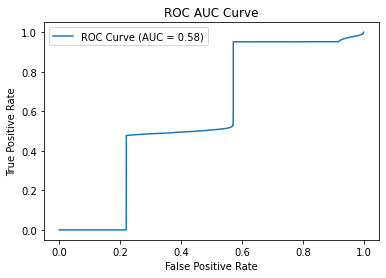

In [32]:
# Plot ROC AUC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC AUC Curve")
plt.show()

In [33]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.spatial.distance import jensenshannon

def calculate_jsd(true_data, generated_data, bins=100):
    """
    Compute the Jensen-Shannon Divergence (JSD) between the true and generated data distributions.
    
    :param true_data: Tensor or numpy array containing the true data.
    :param generated_data: Tensor or numpy array containing the generated data.
    :param bins: Number of bins to discretize the data.
    
    :return: Jensen-Shannon Divergence value.
    """
    # Flatten and convert to numpy arrays
    true_data = true_data.flatten().cpu().detach().numpy()
    generated_data = generated_data.flatten().cpu().detach().numpy()
    
    # Compute the histograms for true and generated data
    true_hist, _ = np.histogram(true_data, bins=bins, density=True)
    gen_hist, _ = np.histogram(generated_data, bins=bins, density=True)
    
    # Add a small value to avoid zero probabilities (log(0) issue)
    epsilon = 1e-8
    true_hist = np.clip(true_hist, epsilon, 1.0)
    gen_hist = np.clip(gen_hist, epsilon, 1.0)
    
    # Normalize histograms to ensure they sum to 1
    true_hist /= true_hist.sum()
    gen_hist /= gen_hist.sum()
    
    # Compute the Jensen-Shannon Divergence
    jsd = jensenshannon(true_hist, gen_hist)
    
    return jsd

# Example usage
if __name__ == "__main__":
    # Simulate some data for testing
    true_data = torch.randn(1000)  # Example true data (e.g., real samples)
    generated_data = torch.randn(1000)  # Example generated data (e.g., fake samples)
    
    jsd_score = calculate_jsd(true_data, generated_data, bins=100)
    print(f"Jensen-Shannon Divergence (Mode Collapse Score): {jsd_score:.4f}")


Jensen-Shannon Divergence (Mode Collapse Score): 0.1632


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Function to compute and print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, average='binary'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Non-Fraud", "Fraud"]))

# Call this function after training the classifier
# Example usage after training loop
y_test_pred = classifier(x_test).argmax(dim=1)
print_evaluation_metrics(y_test.numpy(), y_test_pred.numpy(), average='binary')


/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9861
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      0.99   1270978
       Fraud       0.00      0.00      0.00     17972

    accuracy                           0.99   1288950
   macro avg       0.49      0.50      0.50   1288950
weighted avg       0.97      0.99      0.98   1288950



/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.metrics import matthews_corrcoef

# Function to compute and print MCC along with other metrics
def print_evaluation_metrics_with_mcc(y_true, y_pred, average='binary'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Non-Fraud", "Fraud"]))

# Example usage after training loop
y_test_pred = classifier(x_test).argmax(dim=1)
print_evaluation_metrics_with_mcc(y_test.numpy(), y_test_pred.numpy(), average='binary')


/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Accuracy: 0.9861
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
MCC: 0.0000


/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      0.99   1270978
       Fraud       0.00      0.00      0.00     17972

    accuracy                           0.99   1288950
   macro avg       0.49      0.50      0.50   1288950
weighted avg       0.97      0.99      0.98   1288950



/home/girishkk/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
